# BIBLIOTECAS

In [29]:
# =============================
# script para testes

# Made by: Lucas da Silva Menezes
# 31/07/2023
# =============================

# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt

# import locais
from scripts.calc import *
import scripts.cooling_rate as cooling_rate


**Funções**

In [30]:
def wyoming_read(file_path):

	# NOME DE CADA COLUNA NA SONDAGEM | unidade
	colunas = [
		'pres', # hPa
		'hght', # m
		'temp', # °C
		'dwpt', # °C
		'relh', # %
		'mixr', # g / kg
		'drct', # ° [0, 360]
		'sknt', # Knot
		'thta', # K
		'thte', # K
		'thtv' # K
	]

	# lendo o arquivo
	df = pd.read_csv(
		file_path,
		sep = '\s+',
		names = colunas
	)

	# convertendo para as unidades que serao usadas
	df['temp'] = df.temp + 273.15 # °C para K
	df['dwpt'] = df.dwpt + 273.15 # °C para K

	# Converte a razao de mistura pra kg / kg
	df['mixr'] = df['mixr'] * 1e-3

	# Filtra as colunas necessarias
	df = df[colunas[:-5]]

	# Calcula a densidade do vapor
	df['vapor_density'] = density_water_vapor(
		T = df['temp'],
		Td  = df['dwpt'],
	) # em Kg / m³

	# Calcula o path length [Kg / m²]
	df['u'] = path_length(df['vapor_density'].values, df['hght'].values)

	# converte para g/cm²
	df['u'] = df['u'] * 1e-1

	# Retorna o dataframe
	return df


def read_profile(file_path):
	# lendo o arquivo
	df = pd.read_csv(
		file_path,
		sep = ',',
		converters = dict(
			pres = lambda x: pd.to_numeric(x, errors = 'coerce'),
			air_density = lambda x: pd.to_numeric(x, errors = 'coerce'),
			water_density = lambda x: pd.to_numeric(x, errors = 'coerce'),
			ozone_density = lambda x: pd.to_numeric(x, errors = 'coerce')
		)
	)

	# COLUNA | UNIDADE | DESCRICAO
	# hght | km | altitude
	# pres | mb | Pressão atmosférica
	# temp | K | Temperatura do ar
	# air_density | g / m³ | Densidade da parcela de ar úmido
	# water_density | g / m³ | Densidade do vapor d'água na parcela
	# ozone_density | g / m³ | Densidade do ozonio na parcela

	# Calcula a razao de mistura | Adimensional
	df['mixr'] = df['water_density'] / df["air_density"]

	# Converte a altitude de [km] para [m]
	df['hght'] *= 1e3

	# Calcula o path length do vapor d'agua [g / cm²]
	df['u'] = path_length(df['water_density'].values, df['hght'].values)
	df['u'] = df['u'] * 1e-4 # converte de g / m² para g / cm²

	# Calcula a umidade relativa
	# -------------------------------

	# Densidade do vapor d'agua na parcela SATURADA
	df['relh'] = relative_humidty_from_density(
		Qv = df['water_density'] * 1e-3, # converte de [g/m³] para [Kg/m³]
		T =  df['temp']
	)

	return df

In [31]:
# df = wyoming_read(r".\Dados\sbgl_00z_06ago23.txt")
df = read_profile(r".\Dados\tropical.csv")

In [32]:
df

,hght,pres,temp,air_density,water_density,ozone_density,mixr,u,relh
0,0.0,1013.0000,300,1167.0000,1.900000e+01,5.600000e-05,0.016281,4.204547e+00,7.442454e-01
1,1000.0,904.0000,294,1064.0000,1.300000e+01,5.600000e-05,0.012218,2.604547e+00,7.161619e-01
2,2000.0,805.0000,288,986.9000,9.300000e+00,5.400000e-05,0.009423,1.489547e+00,7.324230e-01
3,3000.0,715.0000,284,875.6000,4.700000e+00,5.100000e-05,0.005368,7.895472e-01,4.742962e-01
4,4000.0,633.0000,277,795.1000,2.200000e+00,4.700000e-05,0.002767,4.445472e-01,3.494985e-01
5,5000.0,559.0000,270,719.9000,1.500000e+00,4.500000e-05,0.002084,2.595472e-01,3.854941e-01
6,6000.0,492.0000,264,650.1000,8.500000e-01,4.300000e-05,0.001307,1.420472e-01,3.377812e-01
7,7000.0,432.0000,257,585.5000,4.700000e-01,4.100000e-05,0.000803,7.604723e-02,3.199980e-01
8,8000.0,378.0000,250,525.8000,2.500000e-01,3.900000e-05,0.000475,4.004723e-02,3.020634e-01
9,9000.0,329.0000,244,470.8000,1.200000e-01,3.900000e-05,0.000255,2.154723e-02,2.444353e-01


**Cooling rate (sem nuvens)**

In [36]:
# ------------- SIGLAS -------------
# cr = cooling rate

# nc = no clouds

# rot = rotational
# cont = continuum
# vib = vibrational
# all =  all bands (rot + cont + vib)

df['cr_nc_rot'] = cooling_rate.no_clouds(
    T = df['temp'].values,
    u = df['u'].values,
    q = df['mixr'].values,
    p = df['pres'].values,
    ur = df['relh'].values,
    band = 'rotational' # Banda rotacional (0 a 1000 cm^-1)
) # [K / day]

df['cr_nc_cont'] = cooling_rate.no_clouds(
    T = df['temp'].values,
    u = df['u'].values,
    q = df['mixr'].values,
    p = df['pres'].values,
    ur = df['relh'].values,
    band = 'continuum' # Banda continuum (10µm)
) # [K / day]

df['cr_nc_vib'] = cooling_rate.no_clouds(
    T = df['temp'].values,
    u = df['u'].values,
    q = df['mixr'].values,
    p = df['pres'].values,
    ur = df['relh'].values,
    band = 'vibrational' # Banda vibrational-rotational (6.3µm)
) # [K / day]

df['cr_nc_all'] = cooling_rate.no_clouds(
    T = df['temp'].values,
    u = df['u'].values,
    q = df['mixr'].values,
    p = df['pres'].values,
    ur = df['relh'].values,
    band = 'all' # Todas as bandas
) # [K / day]

**Figura**

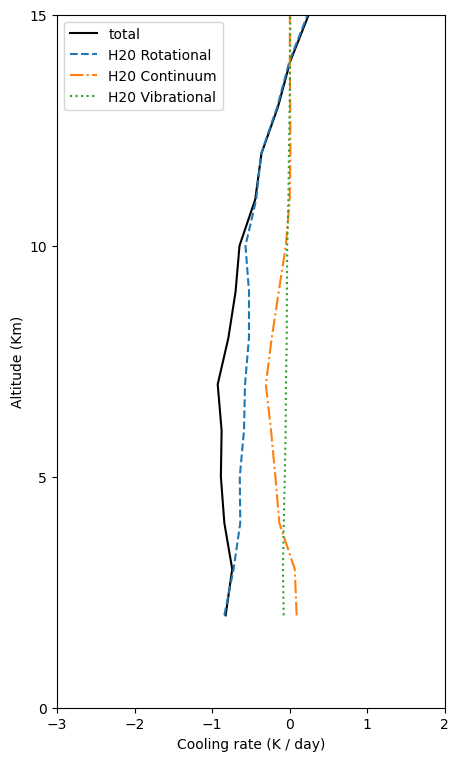

In [34]:
fig, ax  = plt.subplots(figsize = (5, 9))

ax.plot(df['cr_nc_all'], df['hght'] * 1e-3, linestyle = 'solid', color = 'k', label = 'total')
ax.plot(df['cr_nc_rot'], df['hght'] * 1e-3, linestyle =  'dashed', label = 'H20 Rotational')
ax.plot(df['cr_nc_cont'], df['hght'] * 1e-3, linestyle = 'dashdot', label = 'H20 Continuum')
ax.plot(df['cr_nc_vib'], df['hght'] * 1e-3, linestyle = 'dotted', label = 'H20 Vibrational')

# Eixo Y
ax.set_ylim(0, 15)
ax.set_yticks([0, 5, 10, 15])

# Eixo X
left, right = ax.get_xlim()
ax.set_xticks(np.arange(-20, 20, 1))
ax.set_xlim(-3, 2)

# Textos
ax.set_ylabel("Altitude (Km)")
ax.set_xlabel("Cooling rate (K / day)")

# Legenda
plt.legend()

plt.show()